In [7]:
import copy

import pandas as pd
import numpy as np
stock = pd.read_excel('stock.xlsx')  # 股票列表
stock['代码']=stock['代码'].apply(lambda x: str(x))
stock['时间']=pd.to_datetime(stock['时间'])

In [10]:
stock.dtypes

代码                   object
简称                   object
时间           datetime64[ns]
开盘价(元)              float64
收盘价(元)              float64
最高价(元)              float64
最低价(元)              float64
涨跌(元)                object
涨跌幅(%)               object
前收盘价(元)             float64
均价(元)                object
成交量(股)               object
A股流通市值(元)           float64
成交金额(元)              object
B股流通市值(元)            object
换手率(%)               object
总股本(股)                int64
PE市盈率               float64
A股流通股本(股)             int64
PB市净率               float64
B股流通股本(股)            object
PS市销率               float64
PCF市现率              float64
总市值(元)              float64
市盈率TTM              float64
ST股票                 object
*ST股票                object
交易状态                 object
内盘成交量                object
外盘成交量                object
DDX                 float64
dtype: object

In [51]:
def backtest(stock, op, step, init):
    """
    回测
    :param stock: 股票
    :param op: 操作
    :param step: 每次选几只股票
    :param init: 初始资金
    :return:
    """
    stock_list = []
    share_list = []
    date_list = []
    money = [init]
    rate = [0]

    tot = 0
    # temp = copy.deepcopy(op[0:step])
    # temp = temp.reset_index(drop=True)
    avg_money = init / step

    # 初始化 第一次买入
    for i in range(step):
        stock_name = op.loc[i, 'stock']
        date = op.loc[i, 'date']
        price = stock.loc[(stock['代码'] == stock_name) & (stock['时间'] == date)]['开盘价(元)'].iloc[0]

        stock_list.append(stock_name)
        share_list.append(avg_money / price)
        date_list.append(date)

    tot += step
    while tot < len(op):
        start = tot
        temp = copy.deepcopy(op[start:start + step])
        temp = temp.reset_index(drop=True)

        temp_money = 0
        date = temp.loc[0, 'date']

        for i in range(step):
            stock_name = stock_list[tot - step + i]
            price = stock.loc[(stock['代码'] == stock_name) & (stock['时间'] == date)]['开盘价(元)'].iloc[0]
            temp_money += price * share_list[tot - step + i]

        money.append(temp_money)
        rate.append((temp_money-init)/init)
        avg_money = temp_money / step

        for i in range(step):
            stock_name = temp.loc[i, 'stock']
            price = stock.loc[(stock['代码'] == stock_name) & (stock['时间'] == date)]['开盘价(元)'].iloc[0]

            stock_list.append(stock_name)
            share_list.append(avg_money / price)
            date_list.append(date)

        tot += step

    close_date = sorted(stock['时间'])
    close_date = close_date[-1]
    temp_money = 0

    for i in range(step):
        stock_name = stock_list[tot - step + i]
        price = stock.loc[(stock['代码'] == stock_name) & (stock['时间'] == close_date)]['开盘价(元)'].iloc[0]
        temp_money += price * share_list[tot - step + i]

    money.append(temp_money)
    rate.append((temp_money-init)/init)

    op_df = pd.DataFrame(list(zip(date_list, stock_list, share_list)), columns=['date', 'stock_name', 'buy'])
    d = list(op_df['date'].unique())
    d.append(close_date)
    num_df = pd.DataFrame(list(zip(d, money, rate)), columns=['date', 'money', 'rate'])
    return op_df, num_df

In [27]:
g = pd.read_excel('300.xlsx')
g['交易时间'] = pd.to_datetime(g['交易时间'])

In [37]:
def get_300(data, init, date):
    tot = init / data.loc[data['交易时间']==date[0]]['开盘价'].iloc[0]
    rate = [0]
    money = [init]
    for i in date[1:]:
        price = data.loc[data['交易时间']==i]['开盘价'].iloc[0]
        money.append(price * tot)
        rate.append((price * tot - init) / init)
    return money, rate

In [52]:
from matplotlib import pyplot as plt
from pylab import mpl

HuShen = pd.read_excel('300.xlsx')
HuShen['交易时间'] = pd.to_datetime(HuShen['交易时间'])

CAPM, CAPM_num = backtest(stock, pd.read_excel('capm.xlsx'), 5, 1000)
ThreeF, ThreeF_num = backtest(stock, pd.read_excel('ThreeF.xlsx'), 5, 1000)

hs, hs_rate = get_300(HuShen, 1000, list(CAPM_num['date']))

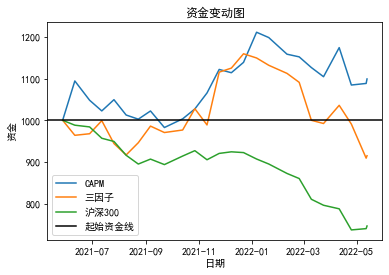

In [53]:
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
plt.plot(CAPM_num['date'], CAPM_num['money'])
plt.plot(ThreeF_num['date'], ThreeF_num['money'])

plt.plot(CAPM_num['date'], hs)
plt.title('资金变动图')
plt.xlabel('日期')
plt.ylabel('资金')
plt.axhline(1000,color='black',label='起始资金线')
plt.legend(['CAPM', '三因子', '沪深300', '起始资金线'])
plt.savefig('资金变化图.png')

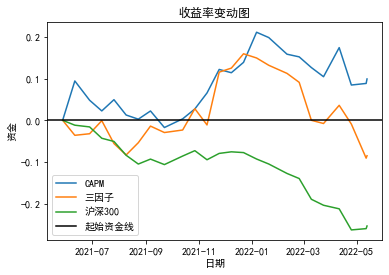

In [55]:
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
plt.plot(CAPM_num['date'], CAPM_num['rate'])
plt.plot(ThreeF_num['date'], ThreeF_num['rate'])

plt.plot(CAPM_num['date'], hs_rate)
plt.title('收益率变动图')
plt.xlabel('日期')
plt.ylabel('资金')
plt.axhline(0,color='black',label='起始资金线')
plt.legend(['CAPM', '三因子', '沪深300', '起始资金线'])
plt.savefig('收益率变化图.png')

In [59]:
print('CAPM方法收益率为{}%'.format((CAPM_num['money'].iloc[-1]-1000) / 10))
print('三因子方法收益率为{}%'.format((ThreeF_num['money'].iloc[-1]-1000) / 10))

CAPM方法收益率为9.91846796072873%
三因子方法收益率为-8.512068246466367%


In [58]:
CAPM_num['money'].iloc[-1]

1099.1846796072873